# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstile data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP. You can get it in the github repo as well as here: http://cosmo.nyu.edu/~fb55/UI_CUSP_2015/data/MTA_Fare.npy. 

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


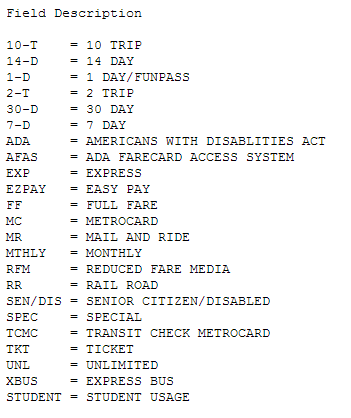

In [1]:
from IPython.display import Image
Image(filename = "Ridetypes.png")

Each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. 

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

## note that the missing values are inputted as -1

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.

In [2]:
import numpy as np
import pandas as pd
import pylab as pl
import statsmodels.api as sm
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
mta = np.load("MTA_Fare.npy")

In [4]:
print mta.shape

(600L, 23L, 194L)


In [5]:
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

In [6]:
#to do calculations, and so that we can use the np.NaN function, we convert to float.
mta = mta.astype(float)

In [7]:
#getting rid of -1 values
mta[mta ==-1] = np.NaN

In [8]:
#for the x axis, we create a dataframe of dates
mta_dates = pd.date_range('05/21/2010', periods=194, freq='W')

In [9]:
#Collapsing across different card types
mta_stations = np.nansum(mta, axis=1)
mta_stations.shape

(600L, 194L)

(array([ 734016.,  734138.,  734258.,  734381.,  734503.,  734624.,
         734747.,  734869.,  734989.,  735112.,  735234.]),
 <a list of 11 Text xticklabel objects>)

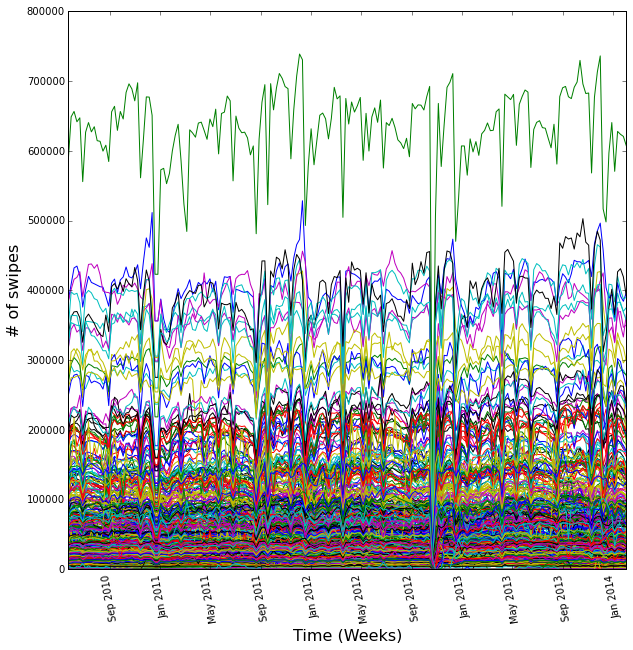

In [19]:
plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(mta_dates, np.transpose(mta_stations))
#we used transpose to get the time on the x axis
pl.ylabel('# of swipes', fontsize = 16)
pl.xlabel('Time (Weeks)', fontsize = 16)
pl.xticks(rotation = 100)

In [11]:
#Calculating threshold to detect events
thresholds = [np.nanmean(mta_stations, axis=1) + 3*np.nanstd(mta_stations, axis=1), 
              np.nanmean(mta_stations, axis=1) - 3*np.nanstd(mta_stations, axis=1)]

In [12]:
#Checking for events
event = [np.where(ts < thresholds[1][i]) for i,ts in enumerate(mta_stations)]
print 'Events that cross the threshold', event[0]

Events that cross the threshold (array([127, 128, 129, 130], dtype=int64),)


### Analysis:

The Event is Huricane Sandy which occoured in Week 127 after May 21st 2010

# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

In [13]:
#collapse cube over stations, to show different fare cards over time
mta_types = np.nansum(mta, axis=0)
print mta_types.shape

(23L, 194L)


In [14]:
#Performing rolling mean
plt.figure(figsize=(10, 10), dpi=200)
smooth_types = pd.rolling_mean(np.transpose(mta_types), 10)
print smooth_types.shape

(194L, 23L)


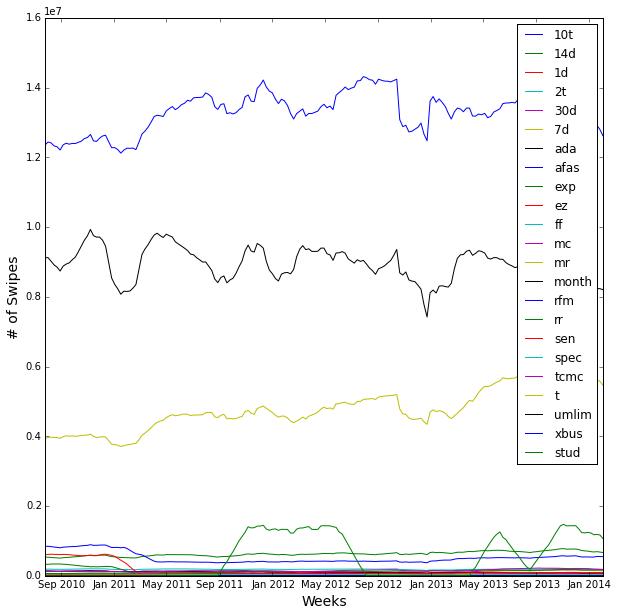

In [21]:
#Plotting
plt.figure(figsize=(10, 10), dpi=200)
ax = pl.plot(mta_dates, smooth_types)
pl.ylabel('# of Swipes', fontsize = 14)
pl.xlabel('Weeks', fontsize = 14)
pl.legend(ridetype)

[  9.85855761e-01   7.96898334e-01   9.01896857e-01   1.07217516e+00
   9.83155326e-01   7.26253084e-01   1.11214933e+00   4.80765217e+03
   9.42633429e+04   6.82381556e+05   1.23714609e+00   8.30622261e-01
   3.89558171e-05   1.74222625e+00   1.54426917e+00   3.87513943e-01
   3.47208425e-01   5.46373828e-02   6.53059649e-01   9.80984190e-01
   1.26020779e+00   6.18746842e-01   0.00000000e+00]


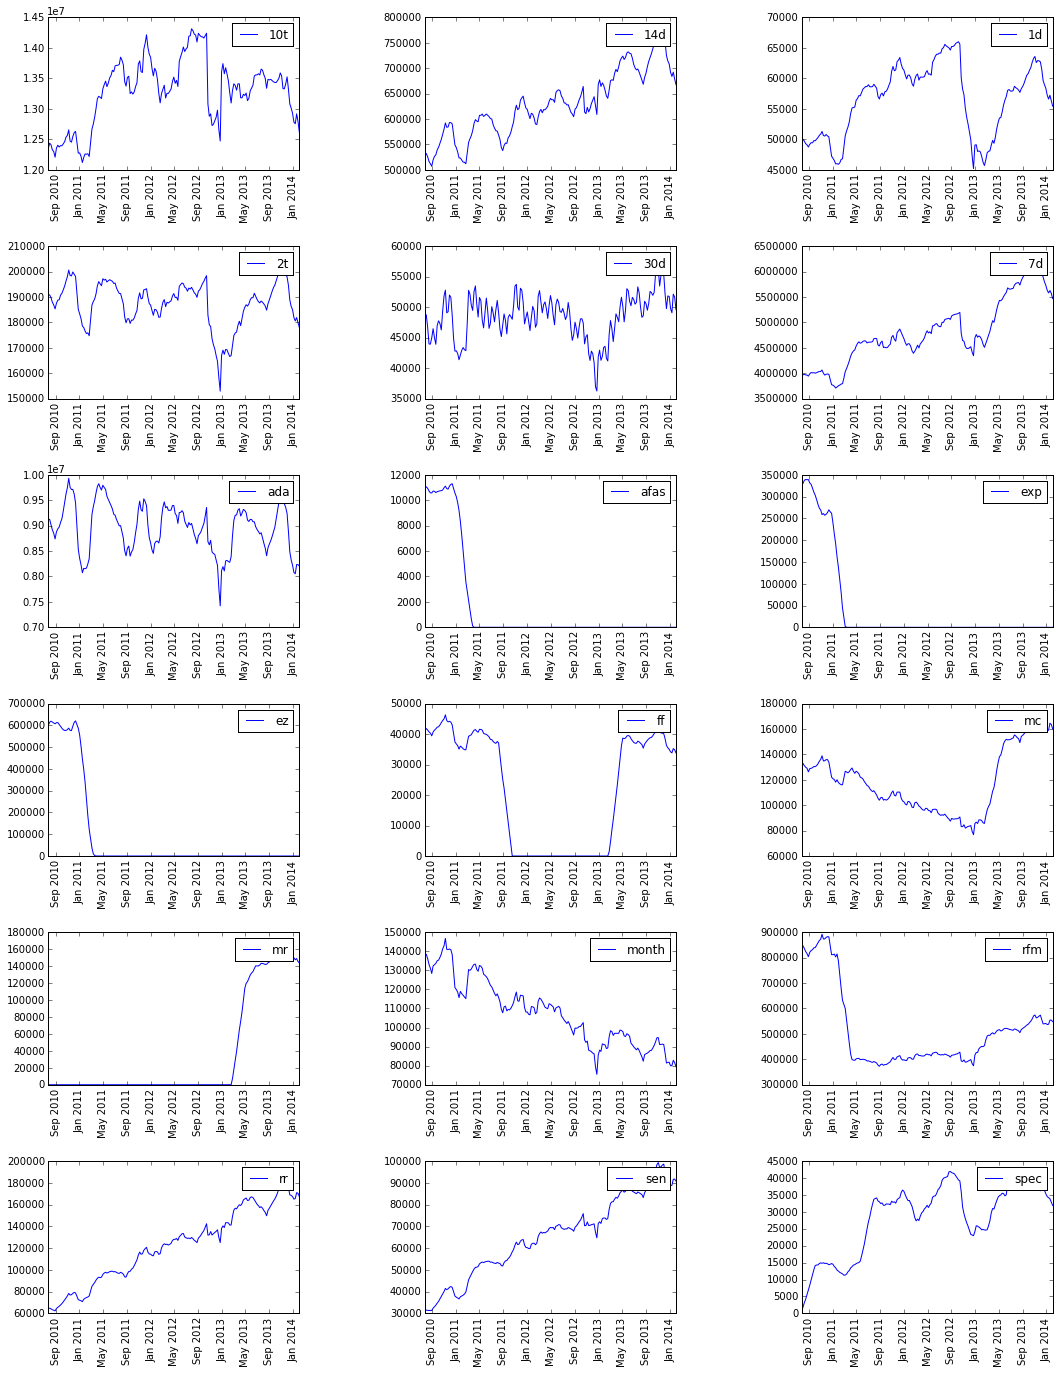

In [22]:
#not my code, got it from a friend

#Calculating ratio of beginning to end for ridertypes
rollingratio = smooth_types[10,:]/smooth_types[193,:]
#Eliminating types that show almost no change
plt.figure(figsize=(18, 18), dpi=200)
n = 1; j = 0
for i in rollingratio:
    if i>0.9 and i<1.1:
        continue
        j += 1
    else:
        pl.subplot(6, 3, n)
        ax = pl.plot(mta_dates, smooth_types[:, j])
        pl.legend(ridetype[j:])
        pl.xticks(rotation = 90)
        n += 1; j += 1
print rollingratio
#spacing out the plots
pl.subplots_adjust(wspace=.5, hspace=.5, left=.125, right=.9, top=1, bottom=0)

### Analysis

In [17]:
trends = [1, 5, 13, 15, 16, 17, 18, 21]

for n in trends:
    if n != 13:
        print '%s rides are getting more frequent at the rate of %f.' % (ridetype[n], rollingratio[n])
    else:
        print '%s rides are getting less frequent at the rate of %f.' % (ridetype[n], rollingratio[n])

14d passes are increasing at an approximate rate of 0.796898.
7d passes are increasing at an approximate rate of 0.726253.
month passes are decreasing at an approximate rate of 1.742226.
rr passes are increasing at an approximate rate of 0.387514.
sen passes are increasing at an approximate rate of 0.347208.
spec passes are increasing at an approximate rate of 0.054637.
tcmc passes are increasing at an approximate rate of 0.653060.
xbus passes are increasing at an approximate rate of 0.618747.


# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)


In [18]:
periods = {}
for i in range(600):
    periods[i] = np.abs(np.fft.rfft(mta_stations[i-1])[4])


import operator
sorted_periods = sorted(periods.items(), key=operator.itemgetter(1))

print("The Station's with the most prominent annual periodicity are")
print(sorted_periods[594:600])

The Station's with the most prominent annual periodicity are
[(540, 1351574.8989024682), (33, 2329896.5813884311), (328, 2402218.5809588572), (151, 2931895.8769513387), (195, 2950388.929214194), (1, 2980160.6355953491)]


### Analysis

The periodicity is perhaps linked to the fall? Maybe people are going back to school

# EXTRA CREDIT: Cluster. 
## Cluster the time series, i.e. identify groups of time series that look similar among each other. You can use KMeans for example to identify common trends, or PCA (Principle Component Analysis). 
## Since this is extra credit I will leave it to you to figure out the details, but for KMeans for e.g. if you use the sklearn.cluster package it would look something like:

## i am flattening the first 2 dimensions of the cube to cluster all light curves for all stations and all types

tots = data.transpose(2,0,1).reshape(data.shape[2], data.shape[1]*data.shape[0]).T

## removing empty light curves
tots = tots[tots.std(1)>0]

## with Kmeans you have to choose the number of clusters ahead km = 

KMeans(n_clusters=10)

## and standardize the lightcurves before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

## then you can run:

km.fit(vals)

# HINTS: 

## When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


# Possibly useful functions

## I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encountered yet which I used. 
## (But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, d) 
     
     which takes as arguments N = the length of your time series (the number of datapoints) and d: the Sample spacing, or 1.0/sampling_rate (in this case, with 1/week sampling, if you want the freq in units of week that is just 1)


*  the np.array.flatten() and np.array.reshape() allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which i recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series)

